# Session 8 - Neural Networks

## Contents

- [Introduction](#Introduction)
- [Optimization and Gradient Descent](#Optimization-and-Gradient-Descent)
- [Deep-Learning](#Deep-Learning)

In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import torch 
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from torchviz import make_dot

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython.display import clear_output

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

While `sklearn` has a library for neural networks, it is very basic and not the standard in the industry. The most commonly used libraries as of 2020 are **Tensorflow** and **Pytorch**.

TensorFlow is developed by Google Brain and actively used at Google both for research and production needs. Its closed-source predecessor is called DistBelief.

PyTorch is a cousin of lua-based Torch framework which was developed and used at Facebook. However, PyTorch is not a simple set of wrappers to support popular language, it was rewritten and tailored to be fast and feel native.

Here is an article that explains very well the difference between the two libraries: [pytorch-vs-tensorflow](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b). In short, pytorch is much more intuitive for a python programmer and more user friendly. It also has a superior development and debugging experience. However, if you want more control on the fundamentals, a better community support and you need to train large models, Tensorflow is better.

## Introduction

Neural Networks in their basic form are just a modification of liner regression. Imagine you had the following model with one dependent variable and two explanatory variables

$$
y = f(x_1, x_2)
$$

One simple model that we could build is the linear model

$$
y = \beta_1 x_1 + \beta_2 x_2
$$

### Tensors

We can express the data as a `numpy` array.

In [4]:
x_np = np.arange(6).reshape((3, 2))
x_np

array([[0, 1],
       [2, 3],
       [4, 5]])

Or equivalently as a `pytorch` tensor.

In [5]:
x_tensor = torch.from_numpy(x_np)
x_tensor

tensor([[0, 1],
        [2, 3],
        [4, 5]])

We can also translate tensors back to arrays.

In [6]:
tensor2array = x_tensor.numpy()
tensor2array

array([[0, 1],
       [2, 3],
       [4, 5]])

We can make operations over this data. For example we can take the mean

In [7]:
try:
    torch.mean(x_tensor)
except Exception as e:
    print(e)

Can only calculate the mean of floating types. Got Long instead.


We first have to convert the data in float

In [8]:
x_tensor = torch.FloatTensor(x_np)
x_tensor

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])

In [9]:
print(np.mean(x_np), '\n\n', torch.mean(x_tensor))

2.5 

 tensor(2.5000)


We can also apply compontent-wise functions

In [10]:
print(np.sin(x_np), '\n\n', torch.sin(x_tensor))

[[ 0.          0.84147098]
 [ 0.90929743  0.14112001]
 [-0.7568025  -0.95892427]] 

 tensor([[ 0.0000,  0.8415],
        [ 0.9093,  0.1411],
        [-0.7568, -0.9589]])


We can multiply tensors as we multiply matrices

In [11]:
print(np.matmul(x_np.T, x_np), '\n\n', torch.mm(x_tensor.T, x_tensor))

[[20 26]
 [26 35]] 

 tensor([[20., 26.],
        [26., 35.]])


But the element-wise multiplication does not work

In [12]:
try:
    x_tensor.dot(x_tensor)
except Exception as e:
    print(e)

1D tensors expected, but got 2D and 2D tensors


### Variables

Variable in torch is to build a computational graph, but this graph is dynamic compared with a static graph in Tensorflow or Theano. So torch does not have placeholder, torch can just pass variable to the computational graph.

In [13]:
# build a variable, usually for compute gradients
x_variable = Variable(x_tensor, requires_grad=True)   

x_variable

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]], requires_grad=True)

Until now the tensor and variable seem the same. However, the variable is a part of the graph, it's a part of the auto-gradient.

Suppose the outcome is 

$$
z = \text{mean} (x_1^2) = \frac{1}{6} x^2
$$

In [14]:
x_2 = torch.mean(x_variable*x_variable)
print(x_2)

tensor(9.1667, grad_fn=<MeanBackward0>)


We can compute the gradient by backpropagation

$$
\nabla z(x) = \frac{2}{3} x
$$

In [15]:
x_2.backward()
print(x_variable.grad)

tensor([[0.0000, 0.3333],
        [0.6667, 1.0000],
        [1.3333, 1.6667]])


In variable format

In [16]:
print(x_variable)

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]], requires_grad=True)


In tensor format

In [17]:
print(x_variable.data)

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])


In numpy format

In [18]:
print(x_variable.data.numpy())

[[0. 1.]
 [2. 3.]
 [4. 5.]]


### Activation function

The main advantage of neural networks is that they introduce non-linearities among the layers. The standard non-linear function 

- ReLu
- Sigmoid
- TanH
- Softmax

In [19]:
# X grid
x_grid = torch.linspace(-5, 5, 200)  # x data (tensor), shape=(100, 1)
x_grid = Variable(x_grid)
x_grid_np = x_grid.data.numpy()   # numpy array for plotting

# Activation functions
y_relu = torch.relu(x_grid).data.numpy()
y_sigmoid = torch.sigmoid(x_grid).data.numpy()
y_tanh = torch.tanh(x_grid).data.numpy()
y_softmax = torch.softmax(x_grid, dim=0).data.numpy() 

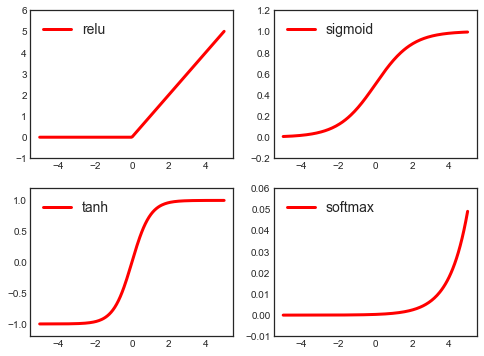

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,6))

# Relu
ax1.plot(x_grid_np, y_relu, c='red', label='relu')
ax1.set_ylim((-1, 6)); ax1.legend()

# Sigmoid
ax2.plot(x_grid_np, y_sigmoid, c='red', label='sigmoid')
ax2.set_ylim((-0.2, 1.2)); ax2.legend()

# Tanh
ax3.plot(x_grid_np, y_tanh, c='red', label='tanh')
ax3.set_ylim((-1.2, 1.2)); ax3.legend()

# Softmax
ax4.plot(x_grid_np, y_softmax, c='red', label='softmax')
ax4.set_ylim((-0.01, 0.06)); ax4.legend();

## Optimization and Gradient Descent

### Gradient Descent

Gradient descent works as follows:

0. Initialize the parameters
1. Compute the Loss
2. Compute the Gradients
3. Update the Parameters
4. Repeat (1)-(3) until convergence

### Gradient Descent in Linear Regression

In order to understand how are NN optimized, we start with a linear regression example. Remember that linear regression can be interpreted as the simplest possible NN.

We generate the following data:

$$
y = 1 + 2 x + \varepsilon
$$

with $x \sim N(0,1)$ and $\varepsilon \sim N(0,0.1)$

In [3]:
# Data Generation
np.random.seed(42)
x = np.sort(np.random.rand(100, 1), axis=0)
e = .1*np.random.randn(100, 1)
y = 1 + 2*x - 3*x**2 + e

Gradient descent with linear regression.

1. Compute the Mean Squared Error
    $$
    \begin{array}
    \text{MSE} &= \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2} \\
          &= \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-a-b x_{i}\right)^{2}
    \end{array}
    $$
    
2. Compute its derivative
    $$
    \begin{array}{l}
    \frac{\partial M S E}{\partial a}=\frac{\partial M S E}{\partial \hat{y}_{i}} \cdot \frac{\partial \hat{y}_{i}}{\partial a}=\frac{1}{N} \sum_{i=1}^{N} 2\left(y_{i}-a-b x_{i}\right) \cdot(-1)=-2 \frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right) \\
    \frac{\partial M S E}{\partial b}=\frac{\partial M S E}{\partial \hat{y}_{i}} \cdot \frac{\partial \hat{y}_{i}}{\partial b}=\frac{1}{N} \sum_{i=1}^{N} 2\left(y_{i}-a-b x_{i}\right) \cdot\left(-x_{i}\right)=-2 \frac{1}{N} \sum_{i=1}^{N} x_{i}\left(y_{i}-\hat{y}_{i}\right)
    \end{array}
    $$
    
3. Update the parameters 
    $$
        \begin{array}{l}
        a=a-\eta \frac{\partial M S E}{\partial a} \\
        b=b-\eta \frac{\partial M S E}{\partial b}
        \end{array}
    $$

In [4]:
# Plot gradient 
def gradient_plot(x, y, y_hat, n_epochs, losses):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    # First figure
    ax1.clear()
    ax1.scatter(x, y)
    ax1.plot(x, y_hat, 'r-')
    ax1.set_title('Data and Fit')
    
    # Second figure
    ax2.clear()
    ax2.plot(range(len(losses)), losses, color='g')
    ax2.set_xlim(0,n_epochs); ax2.set_ylim(0,1.1*np.max(losses))
    ax2.text(n_epochs*0.5, 0.8*np.max(losses), 'Loss=%.4f' % losses[-1], fontdict={'size': 20, 'color':  'g'})
    ax2.set_title('Loss function')
    
    # Plot
    plt.show();

We start by taking a random guess of $\alpha$ and $\beta$.

In [22]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

[0.49671415] [-0.1382643]


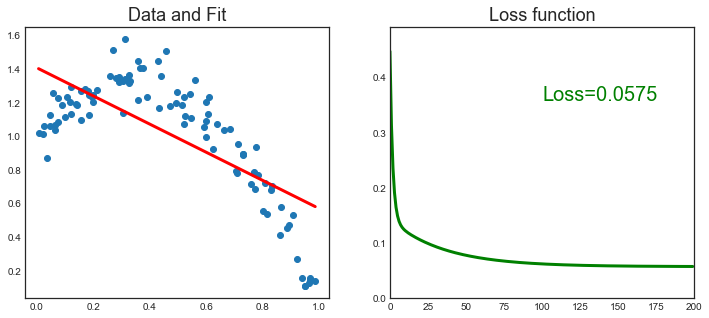

[1.40589939] [-0.83739496]


In [23]:
# Init
lr = 1e-1 # learning rate
n_epochs = 200 # number of epochs
losses = []

# Loop over epochs
for t in range(n_epochs):
    # Computes our model's predicted output
    y_hat = a + b * x
    
    # How wrong is our model? That's the error! 
    error = (y - y_hat)
    
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    losses += [loss]
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
    # Plot
    if (t+1) % 10 == 0:
        gradient_plot(x, y, y_hat, n_epochs, losses)
    
print(a, b)

Sanity Check: do we get the same results as our gradient descent?

In [24]:
# OLS estimates
ols = LinearRegression()
ols.fit(x, y)
print(ols.intercept_, ols.coef_[0])

[1.4345303] [-0.89397853]


Amazing!

Now we are going to do exactly the same but with `pytorch`. First, we convert our data into tensors.

In [25]:
# Convert data to tensors
x_tensor = torch.from_numpy(x).float().to('cpu')
y_tensor = torch.from_numpy(y).float().to('cpu')
print(type(x), type(x_tensor))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


In [26]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to('cpu')
b = torch.randn(1, requires_grad=True, dtype=torch.float).to('cpu')
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to('cpu')
b = torch.randn(1, dtype=torch.float).to('cpu')
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.4476], requires_grad=True) tensor([0.7236], requires_grad=True)
tensor([1.5022], requires_grad=True) tensor([0.8350], requires_grad=True)
tensor([-0.5205], requires_grad=True) tensor([-0.9781], requires_grad=True)


### Autograd

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.

So, how do we tell PyTorch to do its thing and compute all gradients? That’s what backward() is good for.
§
Do you remember the starting point for computing the gradients? It was the loss, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the backward() method from the corresponding Python variable, like, loss.backward().

What about the actual values of the gradients? We can inspect them by looking at the grad attribute of a tensor.

If you check the method’s documentation, it clearly states that gradients are accumulated. So, every time we use the
gradients to update the parameters, we need to zero the gradients afterwards. And that’s what zero_() is good for.

What does the underscore (_) at the end of the method name mean? Do you remember? If not, scroll back to the previous section and find out.

So, let’s ditch the manual computation of gradients and use both backward() and zero_() methods instead.

That’s it? Well, pretty much… but, there is always a catch, and this time it has to do with the update of the parameters…

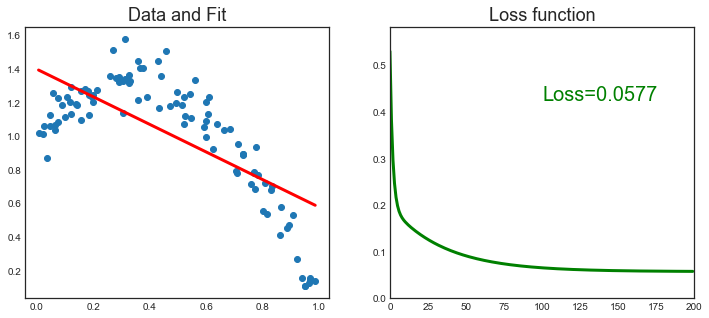

tensor([1.3978], requires_grad=True) tensor([-0.8214], requires_grad=True)


In [27]:
# Init
lr = 1e-1
n_epochs = 200
losses = []

# Init guess
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')
b = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')

# Loop over epochs
for t in range(n_epochs):
    y_hat = a + b * x_tensor
    error = y_tensor - y_hat
    loss = (error ** 2).mean()
    losses += [loss.detach().numpy()]

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    
    # Let's check the computed gradients...
    g = [a.grad.numpy(), b.grad.numpy()]
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
    # Plot
    if (t+1) % 10 == 0:
        gradient_plot(x, y, y_hat.data.numpy(), n_epochs, losses)
    
print(a, b)

### Optimizer


So far, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like SGD or Adam.

An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!

In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters a and b.

In [28]:
# Init parameters
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')
b = torch.randn(1, requires_grad=True, dtype=torch.float, device='cpu')
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


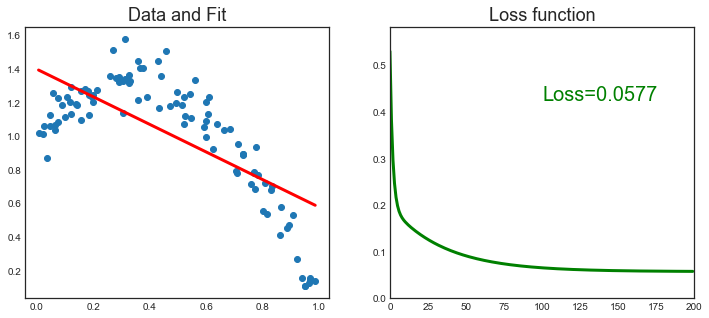

tensor([1.3978], requires_grad=True) tensor([-0.8214], requires_grad=True)


In [29]:
# Init 
lr = 1e-1
n_epochs = 200
losses = []

# Defines a SGD optimizer to update the parameters
optimizer = torch.optim.SGD([a, b], lr=lr)

for t in range(n_epochs):
    y_hat = a + b * x_tensor
    error = y_tensor - y_hat
    loss = (error ** 2).mean()
    losses += [loss.detach().numpy()]
    
    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
    # Plot
    if (t+1) % 10 == 0:
        gradient_plot(x, y, y_hat.data.numpy(), n_epochs, losses)
    
print(a, b)

In our model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model.

Even though this clearly is a contrived example, as we are pretty much wrapping the underlying model without adding anything useful (or, at all!) to it, it illustrates well the concept.

In the __init__ method, we created an attribute that contains our nested Linear model.

In the forward() method, we call the nested model itself to perform the forward pass (notice, we are not calling self.linear.forward(x)!).

In [30]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

Now, if we call the parameters() method of this model, PyTorch will figure the parameters of its attributes in a recursive way. 

In [31]:
[*LinearNet().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([0.2018], requires_grad=True)]

In [32]:
def train_NN(x, y, net, optimizer, loss_func, n_epochs):
    
    # Init
    x_tensor = torch.from_numpy(x).float().to('cpu')
    y_tensor = torch.from_numpy(y).float().to('cpu')
    losses = []

    # Iterate over epochs
    for t in range(n_epochs):

        # input x and predict based on x
        y_hat = net(x_tensor)     

        # compute loss
        loss = loss_func(y_hat, y_tensor)    
        losses += [loss.detach().numpy()]

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        # Plot
        if (t+1) % (n_epochs/25) == 0:
            gradient_plot(x, y, y_hat.data.numpy(), n_epochs, losses)

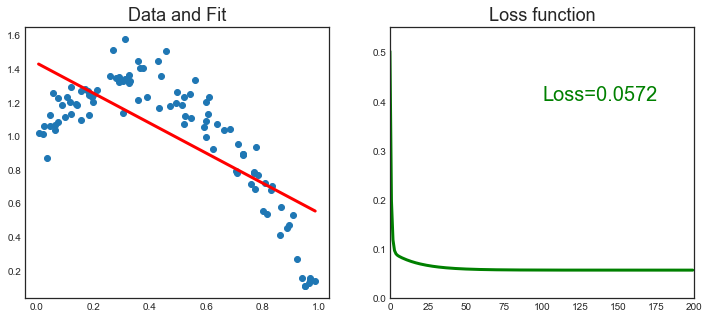

In [33]:
# Define network, optimizer and loss function
net1 = LinearNet()
optimizer = torch.optim.SGD(net1.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
n_epochs = 200

# Train
train_NN(x, y, net1, optimizer, loss_func, n_epochs)

We now define a more complicated NN.

In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = torch.relu(self.hidden(x))  # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [35]:
# ReluNet
net2 = Net(n_feature=1, n_hidden=10, n_output=1)
print(net2)

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


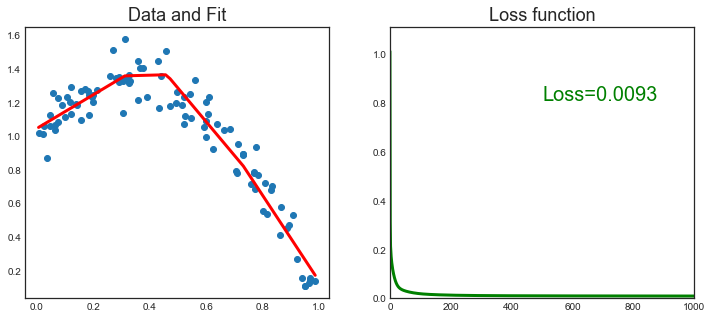

In [36]:
# Define network, optimizer and loss function
optimizer = torch.optim.SGD(net2.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
n_epochs = 1000

# Train
train_NN(x, y, net2, optimizer, loss_func, n_epochs)

We can use more complicated networks

In [37]:
# Generate network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = torch.tanh(self.hidden(x))      # activation function for hidden layer
        y_hat = self.predict(x)         # linear output
        return y_hat

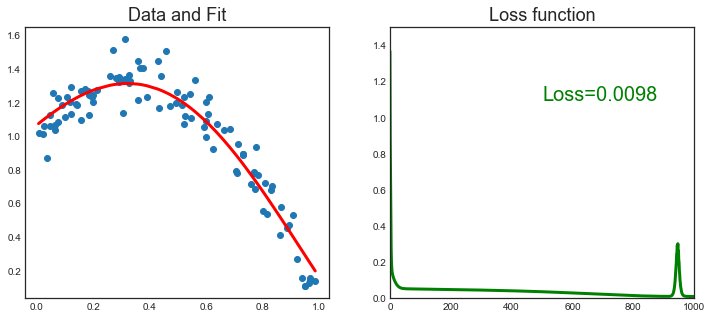

In [38]:
# Define network, optimizer and loss function
net3 = Net(n_feature=1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net3.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
n_epochs = 1000

# Train
train_NN(x, y, net3, optimizer, loss_func, n_epochs)

### An easier way

The is an easier and faster way to build neural networks.

In [5]:
# Easy and fast way to build your network
net4 = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

print(net4)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


### Training on batch

In [6]:
def train_NN_batch(x, y, net, optimizer, loss_func, n_epochs, batch):
    
    # Init
    x_tensor = torch.from_numpy(x).float().to('cpu')
    y_tensor = torch.from_numpy(y).float().to('cpu')
    torch_dataset = Data.TensorDataset(x_tensor, y_tensor)
    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=batch,           # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=2,              # subprocesses for loading data
    )
    losses = []

    # Iterate over epochs
    for t in range(n_epochs):   # train entire dataset 3 times
        for step, (batch_x, batch_y) in enumerate(loader):

            # Compute loss
            y_hat = net(batch_x)     

            # compute loss
            loss = loss_func(y_hat, batch_y)    

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

        # Plot every epoch
        y_hat = net(x_tensor)  
        loss = loss_func(y_hat, y_tensor)    
        losses += [loss.detach().numpy()]
        if (t+1) % (n_epochs/25) == 0:
            gradient_plot(x, y, y_hat.data.numpy(), n_epochs, losses)

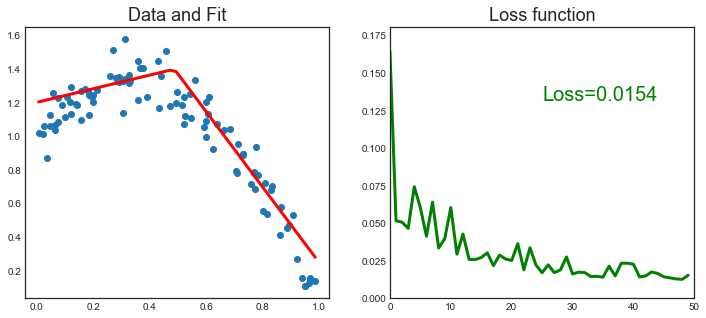

In [7]:
# Define network, optimizer and loss function
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
n_epochs = 50
batch = 5

# Train
train_NN_batch(x, y, net4, optimizer, loss_func, n_epochs, batch)

### Loss functions

We are now going to compare the different loss functions.

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


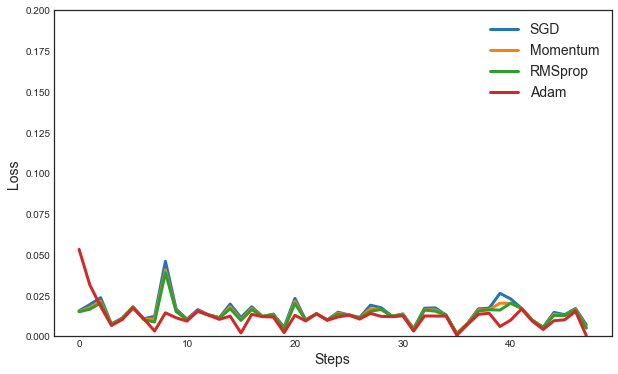

In [15]:
# parameters
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

# Put dateset into torch dataset
x_tensor = torch.from_numpy(x).float().to('cpu')
y_tensor = torch.from_numpy(y).float().to('cpu')
torch_dataset = Data.TensorDataset(x_tensor, y_tensor)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# different nets
net_SGD         = net4
net_Momentum    = net4
net_RMSprop     = net4
net_Adam        = net4
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

# different optimizers
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], []]   # record loss

# training
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):          # for each training step
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data.numpy())     # loss recoder

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()

## Next Session

Jump to [Session 9 - Post-double Selection](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/8_postdoubleselection.ipynb)